# MODEL BIAS


In [8]:
# Importing the necessary packages
!pip install rdkit
!pip install standardiser

import pandas as pd
from rdkit import RDLogger
from standardiser import standardise
import logging
# from os import path, remove

# Disable warning messages
logging.getLogger("standardiser.standardise").setLevel(logging.ERROR)
RDLogger.DisableLog('rdApp.error')
RDLogger.DisableLog('rdApp.warning')

  Using cached rdkit-2023.3.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.5 MB)
     |████████████████████████████████| 698 kB 5.1 MB/s 
  Created wheel for standardiser: filename=standardiser-0.1.9-py3-none-any.whl size=720120 sha256=a8cec44850c263a2355156b8aaede685d7fa6ce71848e5a0375738fcac3008c0
  Stored in directory: /root/.cache/pip/wheels/a5/a7/b4/7f4ed7ad081547dfb4d9a52d6b69981b858d322c67ab27ae22
Successfully built standardiser


In [9]:
# @title 🔗 Connect Colab to your Google Drive

## Mount google drive
from google.colab import drive

drive.mount("/content/drive")

## Click on the folder/directory icon to the left
##      and make sure your drive is mounted

Mounted at /content/drive


<div class="markdown-google-sans">

### 📩 Specify your file paths and the input .csv file
</div>

<div>

*  Make sure you have a .csv file containing a list of molecules represented as SMILES string
* Specify the exact column name of your smiles column in the .csv file
*  Specify the path to your file in Google Drive
*  Specify the path where you want to store the results in Google Drive

</div>

In [10]:
# specify your input folder

input_folder = "/content/drive/MyDrive/Ersilia"  # @param {type:"string"}

In [11]:
# specify your output folder

output_folder = "/content/drive/MyDrive/Ersilia"  # @param {type:"string"}

In [12]:
# specify the name of your input csv file

input_filename = "reference_library"  # @param {type:"string"}

In [13]:
# specify the SMILES column name
smiles_column = "smiles"  # @param {type:"string"}

# Data Cleaning and Preprocessing


I am loading a list of molecules I obtained from ChEMBL and processing them to make sure I have:
- Standard SMILES representation of the compound
- InChIKey associated to the compound

In [14]:
#reading my csv into a pandas data frame
path = "%s/%s.csv" % (input_folder, input_filename)
data = pd.read_csv(path)
data.head(5)

,smiles
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...


In [15]:
#cloning my repo
!git clone 'https://github.com/Hamidatmohd/Ersilia-Model-Evaluation.git'

Cloning into 'Ersilia-Model-Evaluation'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 88 (delta 36), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (88/88), 304.19 KiB | 4.34 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [16]:
# # Converting the molecules to standard SMILES by using the function standardise_smiles from /src

import sys
sys.path.append('/content/Ersilia-Model-Evaluation/src')

from smiles_processing import standardise_smiles

smiles_list = data['smiles'].tolist()
data['standardized_smiles'] = standardise_smiles(smiles_list)

In [19]:
#checking for null values
data.isna().sum()

smiles                 0
standardized_smiles    3
dtype: int64

In [20]:
#dropping the null values
data.dropna(subset=['standardized_smiles'], inplace=True)

In [21]:
#checking the top 5 rows
data.head()

,smiles,standardized_smiles
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1,CCCCNC(=S)N/N=C/c1sccc1C
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1


In [22]:
#extracting inchi key from the smiles
from rdkit import Chem

def smiles_to_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        inchi = Chem.MolToInchi(mol)
        inchikey = Chem.InchiToInchiKey(inchi)
        return inchikey
    else:
        return None

data['inchikey'] = data['standardized_smiles'].apply(smiles_to_inchikey)

# Print the InChIKeys
print(data[['standardized_smiles', 'inchikey']])


                                                smiles  \
0                         CCCCNC(=S)N/N=C/C1=C(C)C=CS1   
1           CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1   
2             O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl   
3    O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...   
4    CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...   
..                                                 ...   
995  CCCN1C(C2=CN=C(NC3=CC=C(C)N=C3)C(Cl)=C2)=NC2=C...   
996   CN(CC1=CC=CC2=CC=CC=C12)CN1N=C(C2=CC=NC=C2)OC1=O   
997  O=C(N[C@@H](CSCC1=CC=CC=C1)C(=O)NC1=CC=C(C2S/C...   
998  CN1CC[C@]23CCCC[C@H]2[C@H]1CC1=CC=C(OC2=CC=CC=...   
999  O=C(CN1C(=O)/C(=C/C2=CC=CO2)SC1=S)NC1=CC=C(C(=...   

                        inchikey  
0    SUTWUYBMBWPLMW-MDWZMJQESA-N  
1    RIYHJWOTNJXDLV-UHFFFAOYSA-N  
2    OGNBARHGQVMGGX-UHFFFAOYSA-N  
3    WQEXDIRUOYNDCM-UHFFFAOYSA-N  
4    YEGVLLQDOGYWDQ-OAHLLOKOSA-N  
..                           ...  
995  RGKVPYQYBUAAEH-UHFFFAOYSA-N  
996  VTRFEMUYHTXFEQ-UHF

In [23]:
data.head()

,smiles,standardized_smiles,inchikey
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1,CCCCNC(=S)N/N=C/c1sccc1C,SUTWUYBMBWPLMW-MDWZMJQESA-N
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,RIYHJWOTNJXDLV-UHFFFAOYSA-N
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,OGNBARHGQVMGGX-UHFFFAOYSA-N
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,WQEXDIRUOYNDCM-UHFFFAOYSA-N
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,YEGVLLQDOGYWDQ-OAHLLOKOSA-N


In [24]:
#extracting the relevant columns
df = pd.DataFrame(data, columns=['standardized_smiles', 'inchikey'])

In [25]:
df

,standardized_smiles,inchikey
0,CCCCNC(=S)N/N=C/c1sccc1C,SUTWUYBMBWPLMW-MDWZMJQESA-N
1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,RIYHJWOTNJXDLV-UHFFFAOYSA-N
2,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,OGNBARHGQVMGGX-UHFFFAOYSA-N
3,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,WQEXDIRUOYNDCM-UHFFFAOYSA-N
4,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,YEGVLLQDOGYWDQ-OAHLLOKOSA-N
...,...,...
995,CCCn1c(-c2cnc(Nc3ccc(C)nc3)c(Cl)c2)nc2cccc(Cl)c21,RGKVPYQYBUAAEH-UHFFFAOYSA-N
996,CN(Cc1cccc2ccccc12)Cn1nc(-c2ccncc2)oc1=O,VTRFEMUYHTXFEQ-UHFFFAOYSA-N
997,O=C(N[C@@H](CSCc1ccccc1)C(=O)Nc1ccc(C2S/C(=N\c...,QDFOYTHIYBSDPW-RGAOVNQFSA-N
998,CN1CC[C@]23CCCC[C@H]2[C@H]1Cc1ccc(Oc2ccccc2F)cc13,YZQZXLROYFNFQE-QTGUNEKASA-N


# Model Bias Evaluation

Now, I will run dataset of 1000 molecules curated above on the Ersilia eos6oli to predict solubility and  use the predictions to see how are they distributed in their space.


In [27]:
#installing miniconda and Ersilia
%%capture
%env MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.12.0-Linux-x86_64.sh
%env MINICONDA_PREFIX=/usr/local
%env PYTHONPATH= "$PYTHONPATH:/usr/local/lib/python3.7/site-packages"
%env PIP_ROOT_USER_ACTION=ignore

In [28]:
!wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT
!chmod +x $MINICONDA_INSTALLER_SCRIPT
!./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

--2024-03-20 08:14:08--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104996770 (100M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh.1’

Miniconda3-py37_4.1 100%[===================>] 100.13M   180MB/s    in 0.6s    

2024-03-20 08:14:08 (180 MB/s) - ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh.1’ saved [104996770/104996770]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | done

# All requested packages already installed.

installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    

In [29]:
!python -m pip install git+https://github.com/ersilia-os/ersilia.git
!python -m pip install requests --upgrade
!python -m pip install pandas
!rm $MINICONDA_INSTALLER_SC

import sys

_ = sys.path.append("/usr/local/lib/python3.7/site-packages")

  Cloning https://github.com/ersilia-os/ersilia.git to /tmp/pip-req-build-liolltnt
  Running command git clone -q https://github.com/ersilia-os/ersilia.git /tmp/pip-req-build-liolltnt
  Resolved https://github.com/ersilia-os/ersilia.git to commit 8f7241ea67bab70a4aec537b5d49660729a1d674
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
rm: missing operand
Try 'rm --help' for more information.


In [30]:
# Enter the model name
# This is just an example, make sure to adapt it to your specific model

model_name = "eos6oli"  # @param {type:"string"}

In [31]:
# @title 📥 Fetch the model
import time

begin = time.time()
!ersilia fetch $model_name
end = time.time()

print("Time taken:", round((end - begin), 2), "seconds")

⬇️  Fetching model eos6oli: soltrannet-aqueous-solubility
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
[]
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
🚀 Serving model eos6oli: soltrannet-aqueous-solubility

   URL: http://127.0.0.1:53585
   PID: 10120
   SRV: conda

👉 To run model:
   - run

💁 Information:
   - info
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
⛔ Model eos6oli closed
👍 Model eos6oli fetched successfully!
Time taken: 228.82 seconds


In [32]:
# @title ⚙️ Serve the model

# returns available APIs (calculate or predict)

!ersilia serve $model_name

sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
🚀 Serving model eos6oli: soltrannet-aqueous-solubility

   URL: http://127.0.0.1:34031
   PID: 10387
   SRV: conda

👉 To run model:
   - run

💁 Information:
   - info


In [33]:
# # Running the predictions

# mdl.serve()
# start = time.time()
# st_smiles = list(data['standardise_smiles'])
# output = mdl.run(st_smiles, output = "pandas")
# end = time.time()
# print("Predictions calculated. Time taken:", end - start)
# mdl.close()

 #@title ⚡ Run predictions
api = "calculate"  # @param {type:"string"}

from ersilia import ErsiliaModel
import time

model = ErsiliaModel(model_name)
begin = time.time()
std_smiles = list(data['standardized_smiles'])
output = model.api(input=std_smiles, output="pandas")
end = time.time()

print("Successful 👍! Time taken:", round((end - begin), 2), "seconds")
model.close()

Successful 👍! Time taken: 64.8 seconds


In [35]:
#printing the predictions as solubility
output

,key,input,solubility
0,SUTWUYBMBWPLMW-MDWZMJQESA-N,CCCCNC(=S)N/N=C/c1sccc1C,-3.454
1,RIYHJWOTNJXDLV-UHFFFAOYSA-N,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,-4.502
2,OGNBARHGQVMGGX-UHFFFAOYSA-N,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,-2.900
3,WQEXDIRUOYNDCM-UHFFFAOYSA-N,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,-4.777
4,YEGVLLQDOGYWDQ-OAHLLOKOSA-N,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,-4.473
...,...,...,...
992,RGKVPYQYBUAAEH-UHFFFAOYSA-N,CCCn1c(-c2cnc(Nc3ccc(C)nc3)c(Cl)c2)nc2cccc(Cl)c21,-7.525
993,VTRFEMUYHTXFEQ-UHFFFAOYSA-N,CN(Cc1cccc2ccccc12)Cn1nc(-c2ccncc2)oc1=O,-4.242
994,QDFOYTHIYBSDPW-RGAOVNQFSA-N,O=C(N[C@@H](CSCc1ccccc1)C(=O)Nc1ccc(C2S/C(=N\c...,-8.070
995,YZQZXLROYFNFQE-QTGUNEKASA-N,CN1CC[C@]23CCCC[C@H]2[C@H]1Cc1ccc(Oc2ccccc2F)cc13,-5.465


In [36]:
#first convert the output into a pandas dataframe
output = pd.DataFrame(output, columns=['key', 'input', 'solubility'])

Text(0.5, 1.0, 'Distribution of Predicted Values')

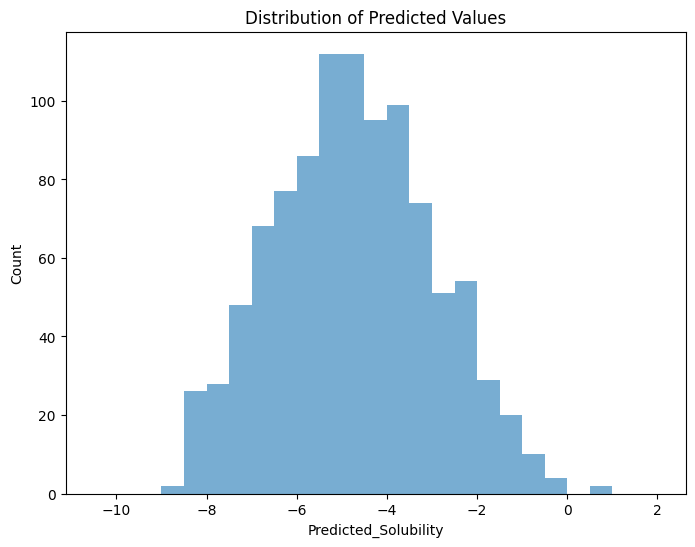

In [44]:
# Plots to observe the distribution of predicted values
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
bins=list(np.arange(-10.5,2.5,.5))

plt.hist(output['solubility'], bins=bins,alpha=0.6)
plt.ylabel('Count')
plt.xlabel('Predicted_Solubility')
plt.title('Distribution of Predicted Values')


# plt.savefig('../plots/predicted_values_histogram.png')


### Result Explanation
 From the output above, the prediction shows negative solubility values. Most of these values fall with the -2 to -6 range judging from the histogram above.

 The negative predicted solubility values might indicate that the chemical structures represented by certain SMILES strings are less soluble in the solvent used in the dataset.
 Negative values may also indicate that the model doesnt fit the dataset accurately and the model might not be well trained with diverse compounds

In [45]:
#@title 💾 Save your results in Google Drive

output_path = "%s/%s_output.csv" % (output_folder, model_name)
output.to_csv(output_path, index=False)